**Introduction**

This codelab walks you through how to use different Search and Store types for indexing embeddings for nearest neighbor lookups, both exact lookup and approximate lookups.
The Indexer uses two components to handle the indexing:


1.   Search: The component that given an embedding looks up k-nearest-neighbors of it
2.   Store: stores and retrievs the metadata associated with a given embedding



The package currently supports the following NN algorithms (Search component):

*   LinearSearch
*   nmslib
*   Faiss

It supports the following Stores:

*   MemoryStore: For small datasets that fit in the memory
*   CachedStore: For medium size datasets that would fit in the memory and disk of the machine
*   RedisStore: For larger datasets that would require a server to store and retrieve the metadata










In [ ]:
# @title install git repo's indexing branch
!git clone https://github.com/tensorflow/similarity.git && cd similarity && git checkout indexing && pip install .[dev] && cd ..

Cloning into 'similarity'...
remote: Enumerating objects: 7082, done.
remote: Counting objects: 100% (1243/1243), done.
remote: Compressing objects: 100% (371/371), done.
remote: Total 7082 (delta 954), reused 1071 (delta 862), pack-reused 5839
Receiving objects: 100% (7082/7082), 166.74 MiB | 17.24 MiB/s, done.
Resolving deltas: 100% (4420/4420), done.
Branch 'indexing' set up to track remote branch 'indexing' from 'origin'.
Switched to a new branch 'indexing'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/similarity
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 92.5 MB/

In [ ]:
# @title check if the package is installed successfully
!pip list | grep tensorflow

tensorflow                    2.11.0
tensorflow-datasets           4.8.3
tensorflow-estimator          2.11.0
tensorflow-gcs-config         2.11.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.31.0
tensorflow-metadata           1.12.0
tensorflow-probability        0.19.0
tensorflow-similarity         0.17.0.dev18


In [ ]:
import gc
import os

import numpy as np
from matplotlib import pyplot as plt
from tabulate import tabulate
import tensorflow as tf
import tensorflow_similarity as tfsim  # main package

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [ ]:
# @title allow gpu memory to grow
tfsim.utils.tf_cap_memory()

In [ ]:
# @title Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.11.0
TensorFlow Similarity 0.17.0.dev18


In [ ]:
# @title load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# @title the sampler
CLASSES = [2, 3, 1, 7, 9, 6, 8, 5, 0, 4]
NUM_CLASSES = 6  # @param {type: "slider", min: 1, max: 10}
CLASSES_PER_BATCH = NUM_CLASSES
EXAMPLES_PER_CLASS = 10  # @param {type:"integer"}
STEPS_PER_EPOCH = 1000  # @param {type:"integer"}

sampler = tfsim.samplers.MultiShotMemorySampler(
    x_train,
    y_train,
    classes_per_batch=CLASSES_PER_BATCH,
    examples_per_class_per_batch=EXAMPLES_PER_CLASS,
    class_list=CLASSES[:NUM_CLASSES],  # Only use the first 6 classes for training.
    steps_per_epoch=STEPS_PER_EPOCH,
)


The initial batch size is 60 (6 classes * 10 examples per class) with 0 augmentations


filtering examples:   0%|          | 0/60000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/6 [00:00<?, ?it/s]

gather examples:   0%|          | 0/36963 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/36963 [00:00<?, ?it/s]

In [ ]:
# @title the model
def get_model():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    # smaller embeddings will have faster lookup times while a larger embedding will improve the accuracy up to a point.
    outputs = tfsim.layers.MetricEmbedding(64)(x)
    return tfsim.models.SimilarityModel(inputs, outputs)


model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                  

Now that we have created the model, we need to load the Store and Search components and pass them to compile to be integrated into the model for indexing.

In [ ]:
# @title load Store and Search components and configure them
from tensorflow_similarity.stores import CachedStore
from tensorflow_similarity.search import LinearSearch

distance = "cosine"  # @param ["cosine", "L2", "L1"]{allow-input: false}
loss = tfsim.losses.MultiSimilarityLoss(distance=distance)
store = CachedStore()
search = LinearSearch(distance, 64)

In [ ]:
# @title compile the model
LR = 0.000005  # @param {type:"number"}
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=loss, kv_store=store, search=search)

Distance metric automatically set to cosine use the distance arg to override.


Epoch 1/10
1000/1000 [==============================] - 118s 113ms/step - loss: 0.8405 - val_loss: 0.4258
Warmup complete
Epoch 2/10
1000/1000 [==============================] - 104s 103ms/step - loss: 0.5207 - val_loss: 0.3958
Epoch 3/10
1000/1000 [==============================] - 105s 105ms/step - loss: 0.3890 - val_loss: 0.3798
Epoch 4/10
1000/1000 [==============================] - 105s 105ms/step - loss: 0.3165 - val_loss: 0.3675
Epoch 5/10
1000/1000 [==============================] - 104s 104ms/step - loss: 0.2556 - val_loss: 0.3642
Epoch 6/10
1000/1000 [==============================] - 101s 101ms/step - loss: 0.2241 - val_loss: 0.3531
Epoch 7/10
1000/1000 [==============================] - 99s 99ms/step - loss: 0.1890 - val_loss: 0.3478
Epoch 8/10
1000/1000 [==============================] - 102s 102ms/step - loss: 0.1654 - val_loss: 0.3437
Epoch 9/10
1000/1000 [==============================] - 99s 99ms/step - loss: 0.1611 - val_loss: 0.3444
Epoch 10/10
1000/1000 [===========

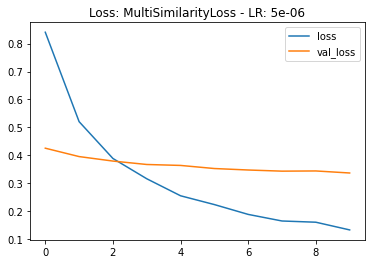

In [ ]:
# @title training
EPOCHS = 10  # @param {type:"integer"}
history = model.fit(sampler, epochs=EPOCHS, validation_data=(x_test, y_test))
# expect loss: 0.14 / val_loss: 0.33
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()

In [ ]:
# @title make index
x_index, y_index = tfsim.samplers.select_examples(x_train, y_train, CLASSES, 20)
model.reset_index()
model.index(x_index, y_index, data=x_index)

filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

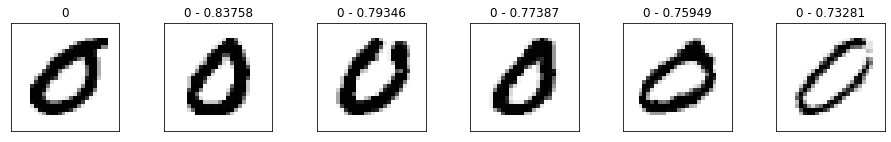

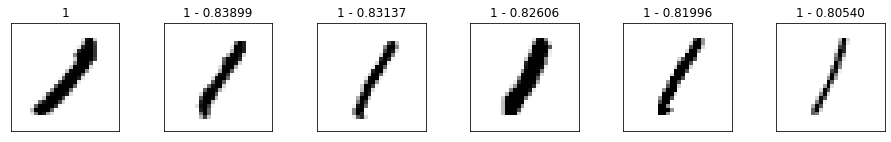

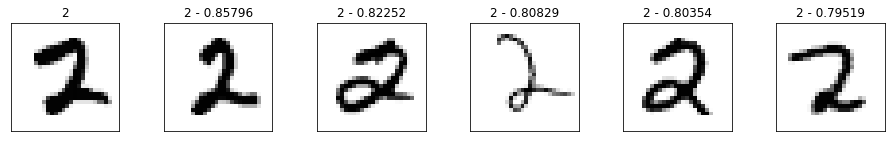

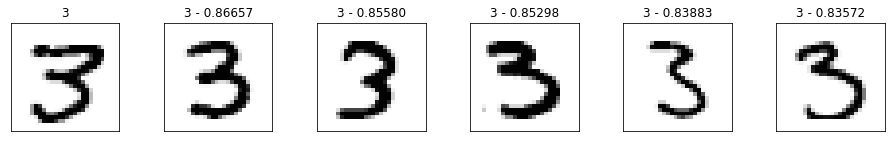

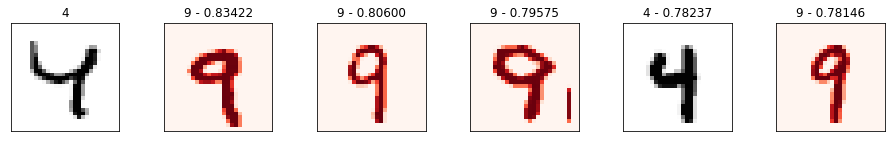

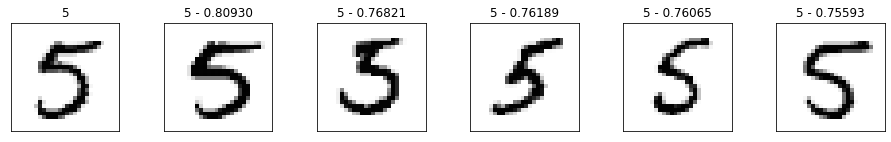

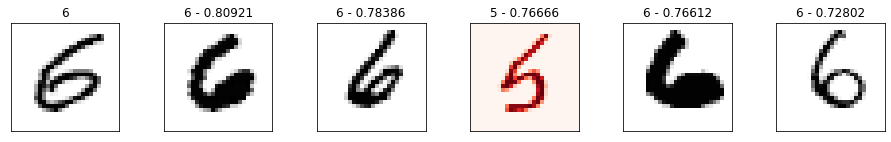

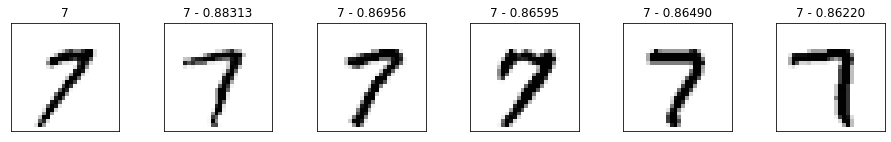

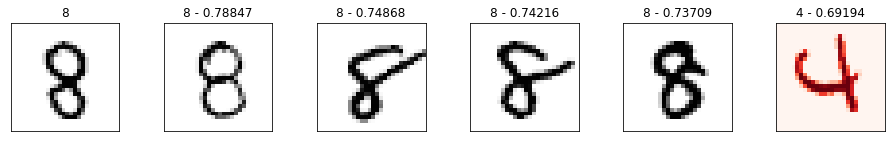

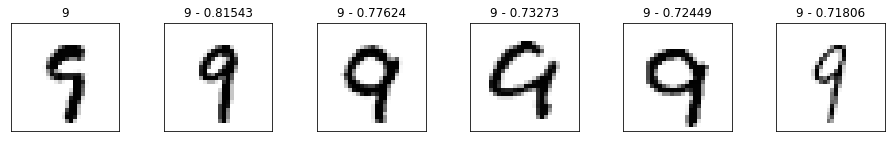

In [ ]:
# @title NN lookup results
# re-run to test on other examples
num_neighbors = 5

# select
x_display, y_display = tfsim.samplers.select_examples(x_test, y_test, CLASSES, 1)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")

In [ ]:
model.index_summary()

[Info]
------------------  ------------
distance            cosine
key value store     CachedStore
search algorithm    LinearSearch
evaluator           memory
index size          200
calibrated          False
calibration_metric  f1
embedding_output
------------------  ------------



[Performance]
-----------  -----------
num lookups  10
min           0.00716727
max           0.00716727
avg           0.00716727
median        0.00716727
stddev        0
-----------  -----------


In [ ]:
# @title save the model and the index
save_path = "models/hello_world"  # @param {type:"string"}
model.save(save_path, save_index=True)

In [ ]:
# @title reload the model
reloaded_model = tf.keras.models.load_model(
    save_path,
    custom_objects={"SimilarityModel": tfsim.models.SimilarityModel},
)
# reload the index
reloaded_model.load_index(save_path)

Distance metric automatically set to cosine use the distance arg to override.
Loading index data
Loading search index


In [ ]:
# @title check the index is back
reloaded_model.index_summary()

[Info]
------------------  ------------
distance            cosine
key value store     CachedStore
search algorithm    LinearSearch
evaluator           memory
index size          200
calibrated          False
calibration_metric  f1
embedding_output
------------------  ------------



[Performance]
-----------  -
num lookups  0
min          0
max          0
avg          0
median       0
stddev       0
-----------  -


filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step

Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

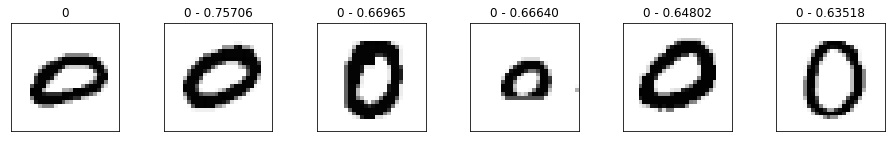

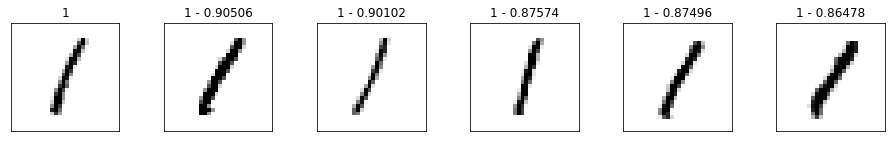

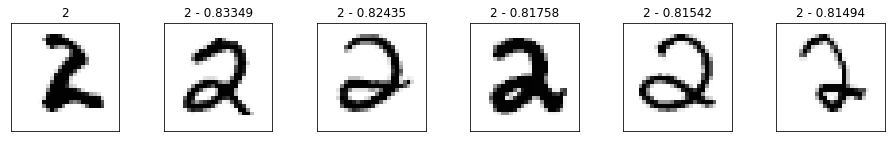

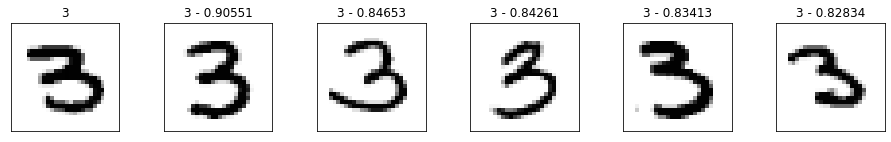

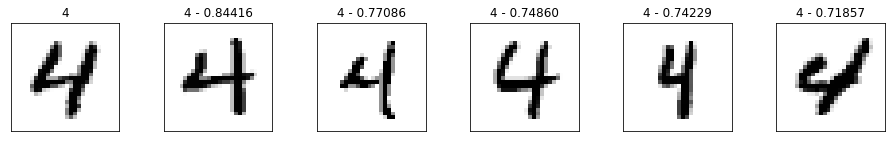

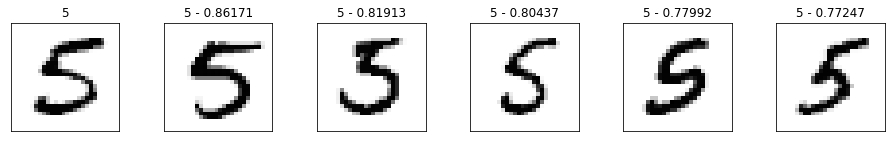

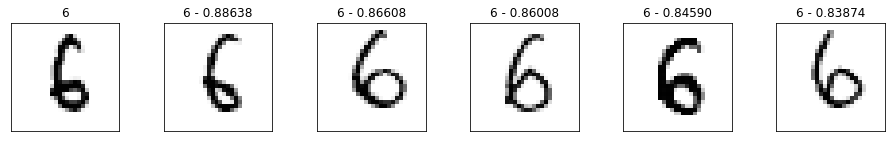

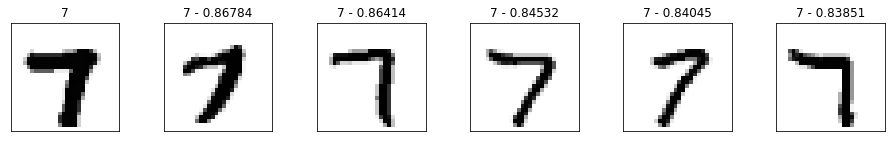

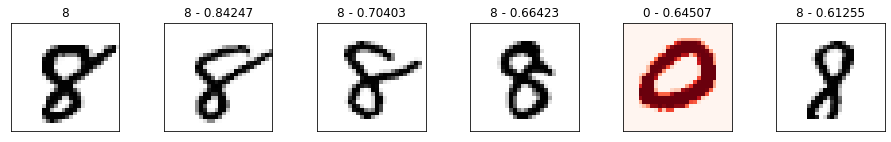

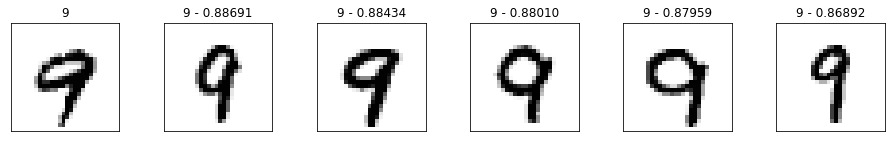

In [ ]:
# @title re-run to test on other examples
num_neighbors = 5

# select
x_display, y_display = tfsim.samplers.select_examples(x_test, y_test, CLASSES, 1)

# lookup the nearest neighbors
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")